# 1. Ventas y Crecimiento 

In [5]:
import pandas as pd
import matplotlib.ticker as ticker

# Configurar Pandas para que no use notación científica
pd.options.display.float_format = '{:,.2f} GBP'.format

In [13]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Esto agrega la carpeta raíz del proyecto al camino de búsqueda de Python
sys.path.append(os.path.abspath(os.path.join('..')))

--- Resumen de Ventas por Periodo ---
           Period       TotalSales
0  Year 2009-2010 9,539,484.63 GBP
1  Year 2010-2011 9,747,765.93 GBP


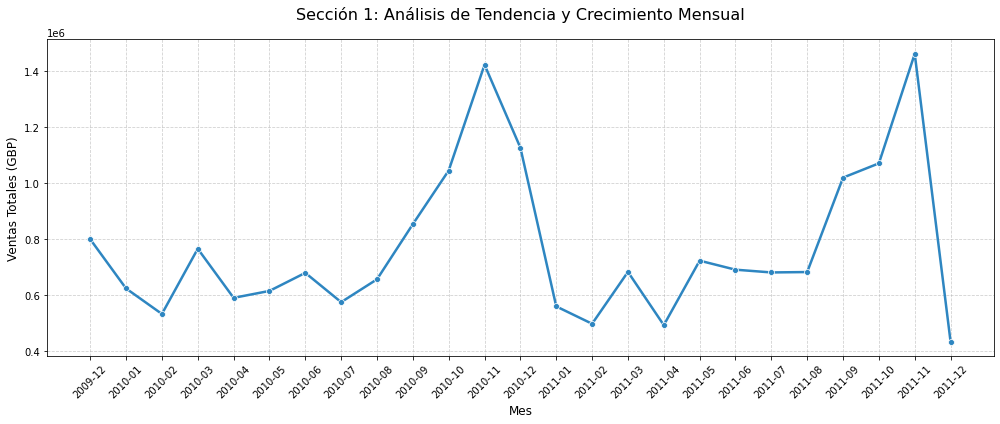

In [14]:
# Importar las nuevas funciones
from src.kpi_engine import get_sales_per_year, get_sales_per_month

# 1. Obtener los datos
df_yearly = get_sales_per_year()
df_monthly = get_sales_per_month()

# 2. Mostrar resumen rápido en texto
print("--- Resumen de Ventas por Periodo ---")
print(df_yearly)

# 3. Graficar la tendencia mensual
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_monthly, x='Month', y='MonthlySales', marker='o', color='#2E86C1', linewidth=2.5)


plt.title('Sección 1: Análisis de Tendencia y Crecimiento Mensual', fontsize=16, pad=20)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Ventas Totales (GBP)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 2. Productos e inventarios 

C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_3936\4063280542.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_revenue, x='TotalRevenue', y='Description', palette='Blues_r', ax=ax1)
C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_3936\4063280542.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_quantity, x='TotalQuantity', y='Description', palette='Oranges_r', ax=ax2)


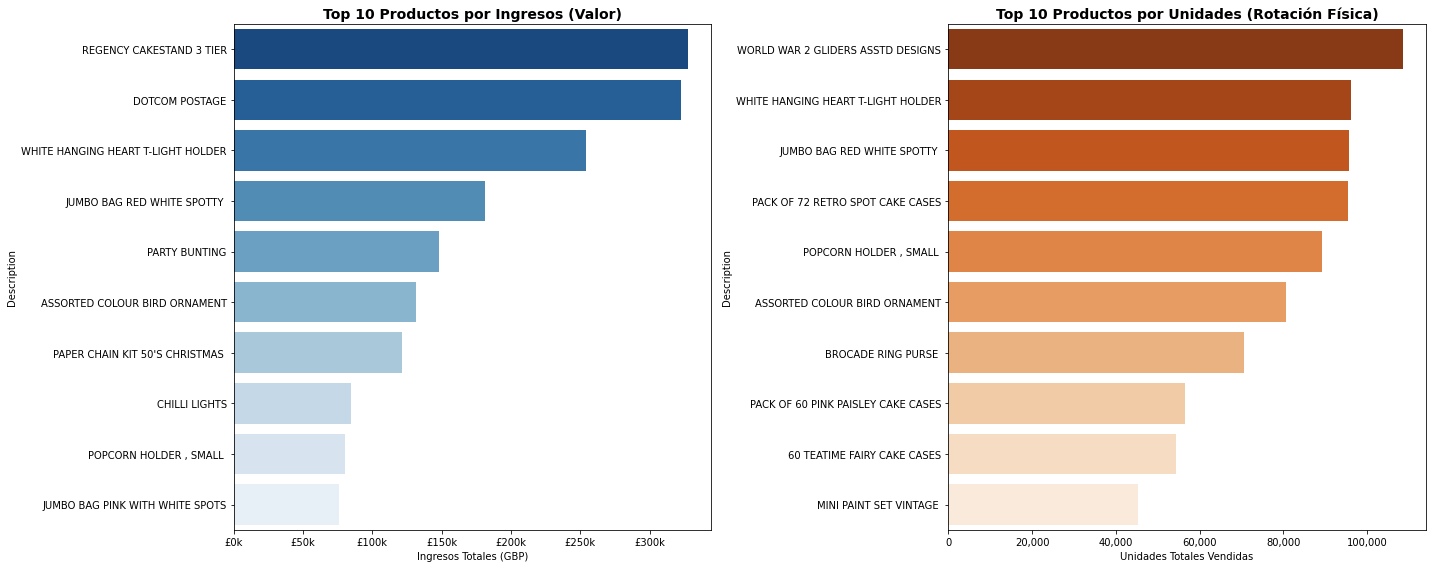

In [15]:
from src.kpi_engine import get_top_products_by_revenue, get_top_products_by_quantity

# 1. Obtener los datos
df_revenue = get_top_products_by_revenue()
df_quantity = get_top_products_by_quantity()

# 2. Configurar visualización doble
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# --- GRÁFICA A: TOP REVENUE ---
sns.barplot(data=df_revenue, x='TotalRevenue', y='Description', palette='Blues_r', ax=ax1)
ax1.set_title('Top 10 Productos por Ingresos (Valor)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Ingresos Totales (GBP)')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'£{x*1e-3:,.0f}k'))

# --- GRÁFICA B: TOP QUANTITY (ROTACIÓN) ---
sns.barplot(data=df_quantity, x='TotalQuantity', y='Description', palette='Oranges_r', ax=ax2)
ax2.set_title('Top 10 Productos por Unidades (Rotación Física)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Unidades Totales Vendidas')
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

# 3. Comportamiento Geográfico

--- 👤 Métricas de Comportamiento del Cliente ---
Gasto Promedio por Cliente: £2,801.80
Órdenes Promedio por Cliente: 7.55 pedidos


C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_3936\2209704366.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_geo.head(10), x='TotalRevenue', y='Country', palette='magma')


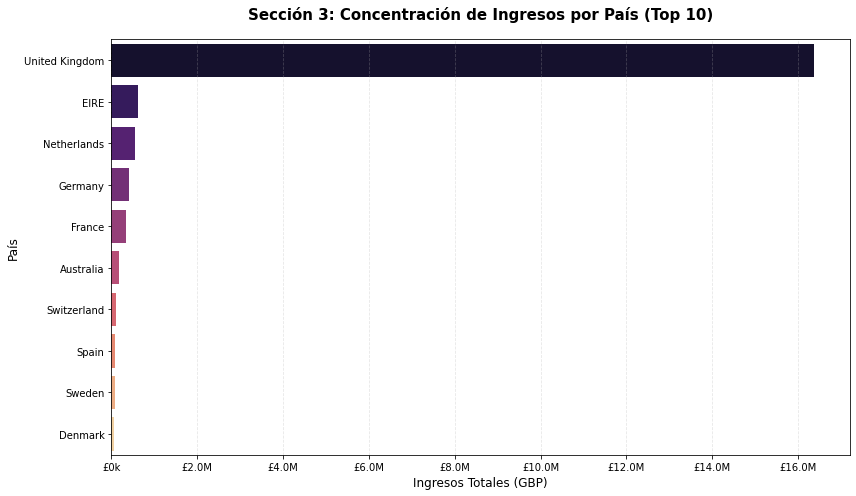

In [16]:
from src.kpi_engine import get_geo_analysis, get_customer_behavior_metrics

# 1. Obtener los datos
df_geo = get_geo_analysis()
df_cust = get_customer_behavior_metrics()

# 2. Mostrar métricas de comportamiento (Texto resaltado)
print("--- 👤 Métricas de Comportamiento del Cliente ---")
print(f"Gasto Promedio por Cliente: £{df_cust['avg_spend_per_customer'][0]:,.2f}")
print(f"Órdenes Promedio por Cliente: {df_cust['avg_orders_per_customer'][0]:,.2f} pedidos")

# 3. Graficar Concentración Geográfica (Top 10 para no saturar)
plt.figure(figsize=(12, 7))
# Usamos escala logarítmica si el UK es demasiado dominante para ver los demás
sns.barplot(data=df_geo.head(10), x='TotalRevenue', y='Country', palette='magma')

# Formatear eje X en Millones/Miles
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'£{x*1e-6:,.1f}M' if x >= 1e6 else f'£{x*1e-3:,.0f}k'))

plt.title('Sección 3: Concentración de Ingresos por País (Top 10)', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Ingresos Totales (GBP)', fontsize=12)
plt.ylabel('País', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Logística y pedidos

--- 📦 Indicadores de Operación Logística ---
Tamaño de Carga Promedio por Pedido: 216.48 unidades/factura


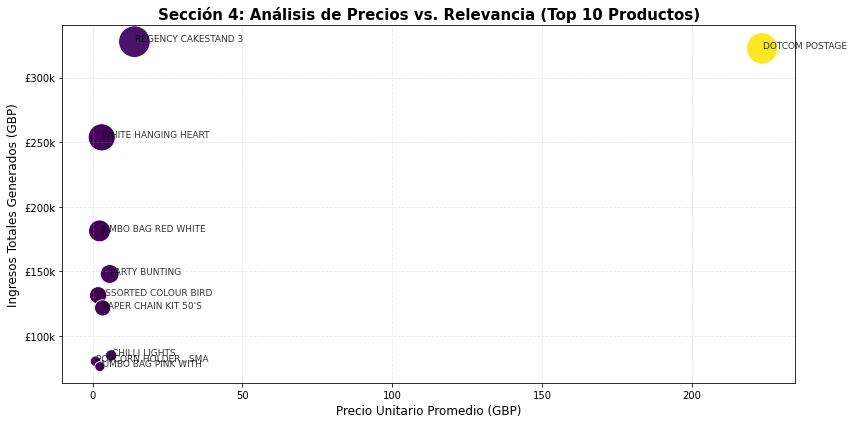


Precio promedio de los 10 productos más vendidos: £26.34


In [17]:
from src.kpi_engine import get_logistics_units_per_order, get_top_products_pricing_analysis

# 1. Obtener los datos
df_units = get_logistics_units_per_order()
df_pricing = get_top_products_pricing_analysis()

# 2. Mostrar KPI Logístico
avg_units = df_units['avg_units_per_order'][0]
print("--- 📦 Indicadores de Operación Logística ---")
print(f"Tamaño de Carga Promedio por Pedido: {avg_units:.2f} unidades/factura")

# 3. Graficar Precio vs. Ingresos de los Top Productos
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(data=df_pricing, x='UnitPrice', y='TotalRevenue', 
                         size='TotalRevenue', sizes=(100, 1000), hue='UnitPrice', palette='viridis', legend=False)

# Añadir etiquetas a los puntos para saber qué producto es
for i in range(df_pricing.shape[0]):
    plt.text(df_pricing.UnitPrice.iloc[i]+0.2, df_pricing.TotalRevenue.iloc[i], 
             df_pricing.Description.iloc[i][:20], fontsize=9, alpha=0.8)

plt.title('Sección 4: Análisis de Precios vs. Relevancia (Top 10 Productos)', fontsize=15, fontweight='bold')
plt.xlabel('Precio Unitario Promedio (GBP)', fontsize=12)
plt.ylabel('Ingresos Totales Generados (GBP)', fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'£{x*1e-3:,.0f}k'))
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Precio promedio del TOP 10
avg_top_price = df_pricing['UnitPrice'].mean()
print(f"\nPrecio promedio de los 10 productos más vendidos: £{avg_top_price:.2f}")